# Imports & functions

In [112]:
# libraries
#%matplotlib notebook
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from statsmodels.tsa.seasonal import seasonal_decompose
from janitor import groupby_agg
from sklearn.ensemble import IsolationForest
from datetime import datetime

In [113]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)


# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [3]:
def mround(x, m=5):
    '''Helper method for multiple round'''
    return int(m * round(float(x)/m))

In [4]:
def set_date_index(input_df, col_name='datevalue'):
    """Given a pandas df, parse and set date column to index.
        col_name will be removed and set as datetime index.

    Args:
        input_df (pandas dataframe): Original pandas dataframe
        col_name (string): Name of date column

    Returns:
        pandas dataframe: modified and sorted dataframe
    """
    # Copy df to prevent changing original
    modified_df = input_df.copy()

    # Infer datetime from col
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])

    # Sort and set index
    modified_df.sort_values(col_name, inplace=True)
    modified_df.set_index(col_name, inplace=True)

    return modified_df

In [5]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    """Adds inplace new seasonal cols to df given seasonal results

    Args:
        input_df (pandas dataframe)
        seasonal_model_results (statsmodels DecomposeResult object)
    """
    # Add results to original df
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

In [6]:
def plot_components(df):
    """Plot data for initial visualization, ultimately visualized in Power BI
    Args:
        df (pandas dataframe)
    """
    df_axis = df.fillna(0)
    ymin = mround(np.min([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymax = mround(np.max([df_axis.observed, df_axis.trend, df_axis.seasonal, df_axis.residual]),5)
    ymin -= 5
    ymax += 5

    plt.figure(figsize=(20,15))

    plt.subplot(4,1,1)
    plt.title("Original Data: {}".format(df))
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.observed)

    plt.subplot(4,1,2)
    plt.title("Trend")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.trend)

    plt.subplot(4,1,3)
    plt.title("Seasonal")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.seasonal)

    plt.subplot(4,1,4)
    plt.title("Residual")
    plt.ylim(ymin, ymax)
    plt.plot(df.index, df.residual)

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

# Data import and cleaning

In [114]:
df = pd.read_csv(r'C:\Users\judit.gyorfi\OneDrive - Irdeto B.V\data for thesis\OneDrive_1_5-3-2021\10ids_1month_9columns-01.csv')
df.head()

,sessionuserid,contentid,detecteduserip,deviceid,licensetype,timestamp_id,region,datevalue,account_id
0,NYC.8150:8150100042909977,579,24.29.98.126,b06fde0f-2215-e910-c3be-15adbbf85810,NaN,1588391432,vir,2020-05-02,twc
1,TWC.999:900028101,XPMV0001585747138001,71.44.2.177,d6ed3c89-1678-8aff-72ff-ff777c383054,NaN,1588393940,vir,2020-05-02,twc
2,NYC.8150:8150100063661101,86,142.129.0.154,xZqmNIDvIG97ROkJ2AAdow==,STREAMING,1588396655,ore,2020-05-02,twc
3,MKE.004:063462105,HTHM0000000001063429,2605:a000:0:8::36,ZjgDP78AWZq5fvg5YI5a2w==,OFFLINE,1588413449,vir,2020-05-02,twc
4,MKE.004:063462105,HTHM0000000001051634,2605:a000:0:8::36,ZjgDP78AWZq5fvg5YI5a2w==,OFFLINE,1588416052,vir,2020-05-02,twc


In [115]:
x = df['deviceid'].value_counts()
x = pd.DataFrame(x)
x[:10]

,deviceid
ZjgDP78AWZq5fvg5YI5a2w==,3200
iWsUvGS3iPDi+FpstT7DIAB1bbU=,1100
DJm2+byMpTWhIYoZG/me2FWCSWo=,920
ScJgJi066fMgVtOsE0GtiNmAH2U=,913
NGJkNmU5MTEzYmFjMjZiM2Q2N2M1MWVhY2ZmOGJiYmE=,743
MEuSR7KPaQX4LFs9H+n0lXrbANQ=,681
ELSKOGgrzmMe5ZALsU8zfs0gKfs=,563
NzY1OTJkOWY3Y2ZlZWY5YTM3NmE2ZDc5YzI1Y2JiZWQ=,560
tJtR62ovaBIt7uKlfSSL4GgcKsI=,544
hgDPrdlOM3O5EPiF0Q0r6Q==,536


In [8]:
calc_percent_NAs(df)

,percent
licensetype,0.387385


In [116]:
content = df.groupby('contentid').agg({'timestamp_id' : 'nunique'}).reset_index().sort_values(by='timestamp_id',ascending=False)
content

,contentid,timestamp_id
2334,86,16555
1472,35,12953
2391,986,3181
254,138,1943
2313,82,1717
...,...,...
3676,HTHM0100000000182629,1
3677,HTHM0100000000182630,1
3678,HTHM0100000000182631,1
3679,HTHM0100000000182632,1


In [117]:
device = df.groupby('deviceid').agg({'timestamp_id' : 'nunique'}).reset_index().sort_values(by='timestamp_id',ascending=False)
device

,deviceid,timestamp_id
23281,ZjgDP78AWZq5fvg5YI5a2w==,3200
28673,iWsUvGS3iPDi+FpstT7DIAB1bbU=,1100
9412,DJm2+byMpTWhIYoZG/me2FWCSWo=,920
18850,ScJgJi066fMgVtOsE0GtiNmAH2U=,909
15425,NGJkNmU5MTEzYmFjMjZiM2Q2N2M1MWVhY2ZmOGJiYmE=,743
...,...,...
13300,JtD7tWq2EPVGBf1+GWm1rA==,1
13301,JtM21YPoiDNaQmldSFGEAw==,1
13302,JtOawsaxcf0SUfnLHZyaYg==,1
13303,JtVio8bvry1bS6NPIBCIpQ==,1


#### Since there are thousands of unique values within the categorical columns, an effective encoding method will be needed

In [118]:
x = df.loc[(df['sessionuserid'] == 'NYC.8150:8150100063661101')]
x

,sessionuserid,contentid,detecteduserip,deviceid,licensetype,timestamp_id,region,datevalue,account_id
2,NYC.8150:8150100063661101,86,142.129.0.154,xZqmNIDvIG97ROkJ2AAdow==,STREAMING,1588396655,ore,2020-05-02,twc
12,NYC.8150:8150100063661101,35,2605:e000:0:8::2e,/LgJ20kKYfbS/39f6aO7Ug==,STREAMING,1588381656,ore,2020-05-02,twc
14,NYC.8150:8150100063661101,35,142.129.0.162,tCsOtrxZv3XbspxYx5l2uQ==,STREAMING,1588402240,ore,2020-05-02,twc
28,NYC.8150:8150100063661101,86,142.129.0.158,+IMaVKH+vJ8H7+xn7FuYjQ==,STREAMING,1588401047,ore,2020-05-02,twc
30,NYC.8150:8150100063661101,86,142.129.0.162,mTYqR8zRq/96wP/yHmCseQ==,STREAMING,1588406502,ore,2020-05-02,twc
...,...,...,...,...,...,...,...,...,...
87237,NYC.8150:8150100063661101,86,142.129.0.158,fls1Pid2jCshwyDqgQ68/w==,STREAMING,1587175945,ore,2020-04-18,twc
87238,NYC.8150:8150100063661101,86,2605:e000:0:8::8e,8twrJumG6e18bhEatvlHNg==,STREAMING,1587181299,ore,2020-04-18,twc
87239,NYC.8150:8150100063661101,86,2605:e000:0:8::2a,tXf+mQWvgkB08vUne33e9A==,STREAMING,1587183041,ore,2020-04-18,twc
87240,NYC.8150:8150100063661101,35,2605:e000:0:8::3e,fgp6cgz/7Dab48Vs5Ol/lg==,STREAMING,1587190016,ore,2020-04-18,twc


Text(0.5, 1.0, 'IP addresses used in time')

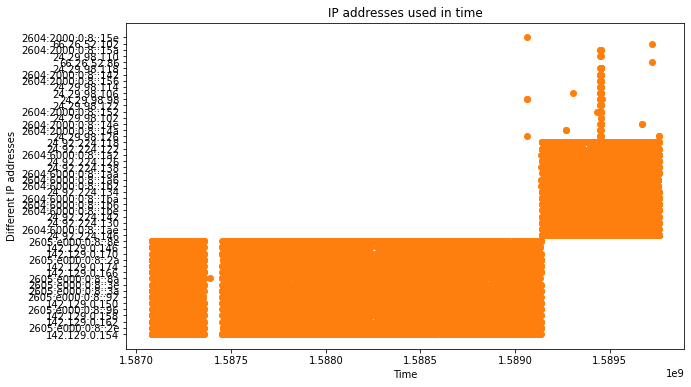

In [119]:
# plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.scatter(x.timestamp_id, x.detecteduserip, color='tab:orange')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Different IP addresses')
ax.set_title('IP addresses used in time')

Text(0.5, 1.0, 'Devices using licenses in the given time frame')

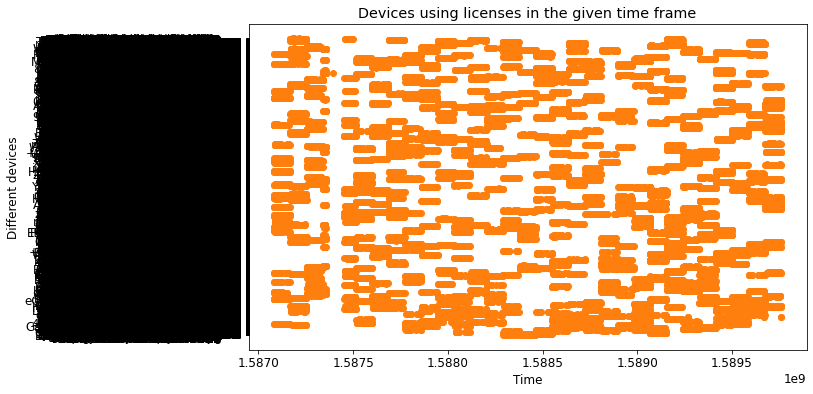

In [13]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.scatter(x.timestamp_id, x.deviceid, color='tab:orange')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Different devices')
ax.set_title('Devices using licenses in the given time frame')

Text(0.5, 1.0, 'Different devices watching different content')

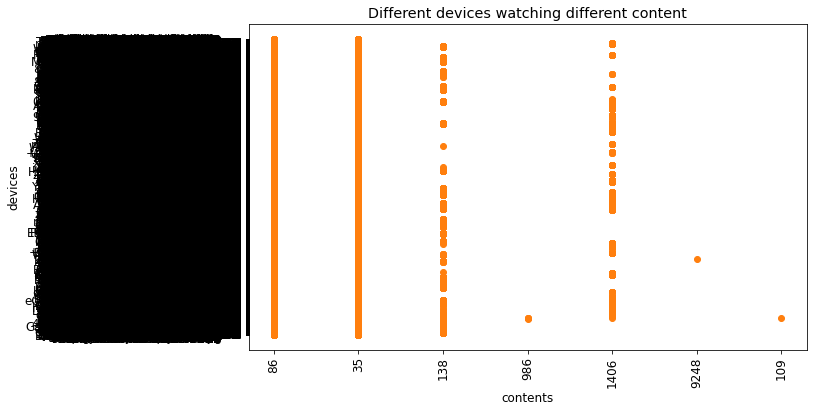

In [14]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.scatter(x.contentid, x.deviceid, color='tab:orange')

# Same as above
ax.set_xlabel('contents')
ax.set_ylabel('devices')
plt.xticks(rotation=90)
ax.set_title('Different devices watching different content')


Text(0.5, 1.0, 'Devices using licenses in the given time frame')

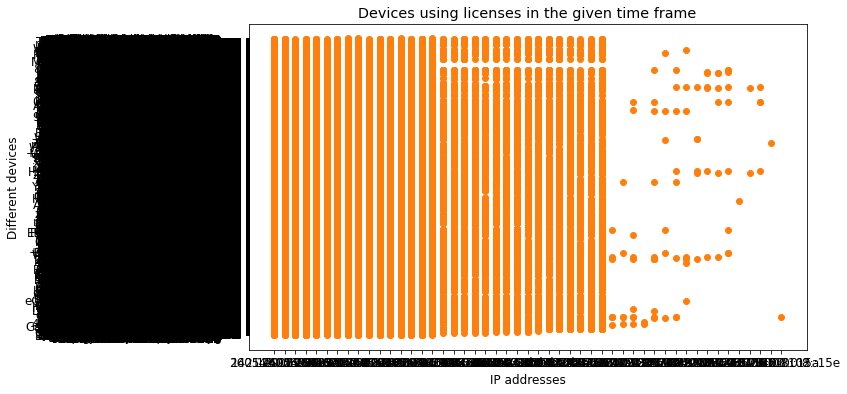

In [15]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.scatter(x.detecteduserip, x.deviceid, color='tab:orange')

# Same as above
ax.set_xlabel('IP addresses')
ax.set_ylabel('Different devices')
ax.set_title('Devices using licenses in the given time frame')

## Combining all the datasets and feature engineering

In [120]:
import os
import glob
os.chdir(r"C:\Users\judit.gyorfi\OneDrive - Irdeto B.V\data for thesis\OneDrive_1_5-3-2021")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
result = pd.concat([pd.read_csv(f) for f in all_filenames])
del result['region']
del result['account_id']
result['LicenseCount'] = 1

#### All the unique values within the whole dataset

In [121]:
unique = result.groupby('contentid').agg({'detecteduserip':'nunique'})
unique = unique.reset_index()
unique

,contentid,detecteduserip
0,0036d003-ace4-4e4d-b877-7e40768ddefa,11
1,0042e5cf-996d-4c61-b326-a579e8ee10a9,1
2,005dbbea-6eb7-44a3-9da8-93039c28301a,2
3,009163b1-410c-4f29-9bcb-34e59e0a6c7f,1
4,00b2f247-a1cc-433a-8e59-a1d175ab9e87,2
...,...,...
37351,move1635220010100004,1
37352,move1639600010100009,1
37353,move1639600030100009,2
37354,move1640040070100004,2


In [122]:
unique = result.groupby('sessionuserid')
unique = unique.agg({'contentid':'nunique','detecteduserip':'nunique','datevalue':'nunique','timestamp_id':'nunique','deviceid':'nunique', })
unique = unique.reset_index()
unique

,sessionuserid,contentid,detecteduserip,datevalue,timestamp_id,deviceid
0,CAK.001:221036902,130,270,331,3085,2272
1,CAR.202:917926801,343,318,344,7141,711
2,CHARTER.8752:8752200300106696,304,43,332,5960,162
3,KYA.003:147067605,2094,316,343,4429,518
4,MKE.004:063462105,395,262,347,8292,881
5,NYC.8150:8150100042909977,14364,10687,402,237676,22011
6,NYC.8150:8150100063661101,88,111,338,350280,331319
7,TWC.999:900028101,27912,33344,398,625337,22581


In [123]:
result_1 = result.copy()

In [124]:
result_2 = result_1.groupby(['sessionuserid','contentid','detecteduserip','datevalue','deviceid','timestamp_id']).agg('sum').sort_values(by=['LicenseCount'], ascending=True)

In [125]:
result_3 = result_2.reset_index()

#### Modifying datetime features

In [127]:
result_3['datevalue'] = pd.to_datetime(result_3.datevalue, format='%Y-%m-%d')
result_3['DayOfTheWeek'] = result_3['datevalue'].dt.dayofweek
result_3['DayOfTheYear'] = result_3['datevalue'].dt.dayofyear
result_3['WeekDay'] = (result_3['DayOfTheWeek'] <= 5).astype(int)
result_3

,sessionuserid,contentid,detecteduserip,datevalue,deviceid,timestamp_id,LicenseCount,DayOfTheWeek,DayOfTheYear,WeekDay
0,CAK.001:221036902,102,2605:a000:0:8:9::2a,2020-06-27,gAUf+7RopLwjGjWeyD819A==,1593282962,1,5,179,1
1,TWC.999:900028101,1937,72.179.205.226,2020-06-05,eqRXtLYzUSoN587u6h+M7ae5d28=,1591327728,1,4,157,1
2,TWC.999:900028101,1937,72.179.205.226,2020-06-03,5+wXf4e9zLii4hV+JTT165oryAE=,1591148620,1,2,155,1
3,TWC.999:900028101,1937,72.179.205.226,2020-06-03,1Guu4/WvC0eKbwm2ShIKGQfSY24=,1591153861,1,2,155,1
4,TWC.999:900028101,1937,72.179.205.226,2020-06-01,ZgewY2wXc9tZpgg8EIrFKPydg10=,1590982064,1,0,153,1
...,...,...,...,...,...,...,...,...,...,...
1312976,NYC.8150:8150100063661101,35,67.254.184.244,2020-08-01,p3vI4wfafnfrKuShDstdKdbVmB8=,1596264901,8,5,214,1
1312977,NYC.8150:8150100042909977,986,107.221.239.107,2020-12-15,OGVmY2Q4MmE0Y2IwNmYzOTFkMjA5N2ZlMzVjOTg4MmY=,1607990413,8,1,350,1
1312978,NYC.8150:8150100042909977,986,107.221.239.107,2020-12-14,OGVmY2Q4MmE0Y2IwNmYzOTFkMjA5N2ZlMzVjOTg4MmY=,1607987629,8,0,349,1
1312979,NYC.8150:8150100042909977,986,107.221.239.107,2020-12-14,OGVmY2Q4MmE0Y2IwNmYzOTFkMjA5N2ZlMzVjOTg4MmY=,1607989507,9,0,349,1


In [128]:
result_3['datetime'] = pd.to_datetime(result_3['timestamp_id'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))
result_3 = result_3.set_index(result_3['datetime'])
result_3

,sessionuserid,contentid,detecteduserip,datevalue,deviceid,timestamp_id,LicenseCount,DayOfTheWeek,DayOfTheYear,WeekDay,datetime
datetime,,,,,,,,,,,
2020-06-27 20:36:02,CAK.001:221036902,102,2605:a000:0:8:9::2a,2020-06-27,gAUf+7RopLwjGjWeyD819A==,1593282962,1,5,179,1,2020-06-27 20:36:02
2020-06-05 05:28:48,TWC.999:900028101,1937,72.179.205.226,2020-06-05,eqRXtLYzUSoN587u6h+M7ae5d28=,1591327728,1,4,157,1,2020-06-05 05:28:48
2020-06-03 03:43:40,TWC.999:900028101,1937,72.179.205.226,2020-06-03,5+wXf4e9zLii4hV+JTT165oryAE=,1591148620,1,2,155,1,2020-06-03 03:43:40
2020-06-03 05:11:01,TWC.999:900028101,1937,72.179.205.226,2020-06-03,1Guu4/WvC0eKbwm2ShIKGQfSY24=,1591153861,1,2,155,1,2020-06-03 05:11:01
2020-06-01 05:27:44,TWC.999:900028101,1937,72.179.205.226,2020-06-01,ZgewY2wXc9tZpgg8EIrFKPydg10=,1590982064,1,0,153,1,2020-06-01 05:27:44
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 08:55:01,NYC.8150:8150100063661101,35,67.254.184.244,2020-08-01,p3vI4wfafnfrKuShDstdKdbVmB8=,1596264901,8,5,214,1,2020-08-01 08:55:01
2020-12-15 01:00:13,NYC.8150:8150100042909977,986,107.221.239.107,2020-12-15,OGVmY2Q4MmE0Y2IwNmYzOTFkMjA5N2ZlMzVjOTg4MmY=,1607990413,8,1,350,1,2020-12-15 01:00:13
2020-12-15 00:13:49,NYC.8150:8150100042909977,986,107.221.239.107,2020-12-14,OGVmY2Q4MmE0Y2IwNmYzOTFkMjA5N2ZlMzVjOTg4MmY=,1607987629,8,0,349,1,2020-12-15 00:13:49


#### Adding 'average content per device feature'

In [25]:
group_1 = result_3.groupby(['deviceid','datevalue']).mean().sort_values(by='LicenseCount',ascending=False)
group_1 = group_1.reset_index()
group_1 = group_1.rename(columns={'LicenseCount': 'avg_content_per_device'})
group_1

,deviceid,datevalue,timestamp_id,avg_content_per_device,DayOfTheWeek,WeekDay
0,Kqis0cFu5Ig3QNSuzug96jEegro=,2021-01-24,1.611462e+09,3.500000,6.0,0
1,tXqKnTyTu7lYyQYx8D1j6jGFojw=,2020-10-27,1.603828e+09,3.000000,1.0,1
2,iK6tDNMpLkzFvxVLCztnGRpAKP4=,2021-01-28,1.611809e+09,3.000000,3.0,1
3,4buIb9bHlDSYYE3PzACBzi2kSnU=,2020-12-27,1.609079e+09,3.000000,6.0,0
4,jmBEkoDwu6BU5YKQFwbNJfhuGx8=,2021-01-07,1.609997e+09,2.333333,3.0,1
...,...,...,...,...,...,...
514000,KQWqQKUcfgn0T3axZpN4eEonvPo=,2020-12-28,1.609128e+09,1.000000,0.0,1
514001,KQWqQKUcfgn0T3axZpN4eEonvPo=,2020-12-27,1.609100e+09,1.000000,6.0,0
514002,KQWqQKUcfgn0T3axZpN4eEonvPo=,2020-12-25,1.608866e+09,1.000000,4.0,1
514003,KQWqQKUcfgn0T3axZpN4eEonvPo=,2020-12-24,1.608789e+09,1.000000,3.0,1


In [26]:
result_4 = pd.merge(result_3,group_1[['deviceid','avg_content_per_device']], on=['deviceid'],how='left')
result_4.sort_values(by='avg_content_per_device', ascending=False)

,sessionuserid,contentid,detecteduserip,datevalue,deviceid,timestamp_id,LicenseCount,DayOfTheWeek,WeekDay,datetime,avg_content_per_device
116435399,NYC.8150:8150100063661101,426,64.225.7.95,2021-01-24,Kqis0cFu5Ig3QNSuzug96jEegro=,1611467131,6,6,0,2021-01-24 06:45:31,3.5
115739002,NYC.8150:8150100063661101,426,64.225.7.95,2021-01-24,Kqis0cFu5Ig3QNSuzug96jEegro=,1611456636,1,6,0,2021-01-24 03:50:36,3.5
115738994,NYC.8150:8150100063661101,426,64.225.7.95,2021-01-24,Kqis0cFu5Ig3QNSuzug96jEegro=,1611467130,1,6,0,2021-01-24 06:45:30,3.5
116435398,NYC.8150:8150100063661101,426,64.225.7.95,2021-01-24,Kqis0cFu5Ig3QNSuzug96jEegro=,1611456637,6,6,0,2021-01-24 03:50:37,3.5
94103564,NYC.8150:8150100042909977,NBCU0402437000610089,72.179.205.230,2020-02-06,tXqKnTyTu7lYyQYx8D1j6jGFojw=,1581014540,1,3,1,2020-02-06 19:42:20,3.0
...,...,...,...,...,...,...,...,...,...,...,...
39618489,TWC.999:900028101,82,2607:fb90:de56:dee7:0:3b:4e3:6201,2020-11-03,NDgxZGVjZGQxMGZiYmNkZjY4Mjk4Y2VkMWUyMTg5NWY=,1604368194,1,1,1,2020-11-03 02:49:54,1.0
39618488,TWC.999:900028101,82,2607:fb90:de56:dee7:0:3b:4e3:6201,2020-11-03,NDgxZGVjZGQxMGZiYmNkZjY4Mjk4Y2VkMWUyMTg5NWY=,1604368194,1,1,1,2020-11-03 02:49:54,1.0
39618487,TWC.999:900028101,82,2607:fb90:de56:dee7:0:3b:4e3:6201,2020-11-03,NDgxZGVjZGQxMGZiYmNkZjY4Mjk4Y2VkMWUyMTg5NWY=,1604368194,1,1,1,2020-11-03 02:49:54,1.0
39618486,TWC.999:900028101,82,2607:fb90:de56:dee7:0:3b:4e3:6201,2020-11-03,NDgxZGVjZGQxMGZiYmNkZjY4Mjk4Y2VkMWUyMTg5NWY=,1604368194,1,1,1,2020-11-03 02:49:54,1.0


#### Adding 'Number of unique device_ids, content_ids, ip_addresses '

In [27]:
group_2 = result_3.groupby('sessionuserid').agg({'contentid':'nunique','detecteduserip':'nunique','deviceid':'nunique'})
group_2 = group_2.reset_index()
group_2 = group_2.rename(columns={'detecteduserip': 'nr_of_IP_per_user','contentid':'nr_of_content_per_user', 'deviceid':'nr_of_device_per_user'})
group_2

,sessionuserid,nr_of_content_per_user,nr_of_IP_per_user,nr_of_device_per_user
0,CAK.001:221036902,130,270,2272
1,CAR.202:917926801,343,318,711
2,CHARTER.8752:8752200300106696,304,43,162
3,KYA.003:147067605,2094,316,518
4,MKE.004:063462105,395,262,881
5,NYC.8150:8150100042909977,14364,10685,22011
6,NYC.8150:8150100063661101,88,111,331319
7,TWC.999:900028101,27910,33336,22581


In [28]:
result_4 = pd.merge(result_4,group_2[['sessionuserid', 'nr_of_content_per_user','nr_of_IP_per_user','nr_of_device_per_user']], on=['sessionuserid'],how='left')
result_4.head()

MemoryError: Unable to allocate 888. MiB for an array with shape (116437197,) and data type int64

#### Adding 'how many times an IP address has been used per device'

In [ ]:
group_3 = result_3.groupby(['deviceid','detecteduserip']).sum().sort_values(by='LicenseCount',ascending=False)
group_3 = group_3.reset_index()
group_3 = group_3.rename(columns={'LicenseCount': 'nr_of_IP_per_device'})
group_3

In [ ]:
result_4 = pd.merge(result_4,group_3[['deviceid', 'detecteduserip','nr_of_IP_per_device']], on=['deviceid','detecteduserip'],how='left')
result_4.head()

#### Adding 'Avg number of deviceid per contentid'

In [ ]:
group_4 = result_3.groupby(['contentid','deviceid']).mean().sort_values(by='LicenseCount',ascending=False)
group_4 = group_4.reset_index()
group_4 = group_4.rename(columns={'LicenseCount': 'avg_nr_of_device_per_content'})
group_4

In [ ]:
result_4 = pd.merge(result_4,group_4[['deviceid','contentid','avg_nr_of_device_per_content']], on=['contentid','deviceid'],how='left')
result_4.head()

#### Adding 'maximum number of licensecounts per content_id'

In [ ]:
group_5 = result_3.groupby(['contentid']).max().sort_values(by='LicenseCount',ascending=False)
group_5 = group_5.reset_index()
group_5 = group_5.rename(columns={'LicenseCount': 'max_nr_of_licensecount_per_content'})
group_5

In [ ]:
result_4 = pd.merge(result_4,group_5[['contentid','max_nr_of_licensecount_per_content']], on=['contentid'],how='left')
result_4

## Feature engineering II.

#### Cleaning

In [129]:
df = result.copy()

In [130]:
df.isnull().sum()

sessionuserid          0
contentid              0
detecteduserip         0
deviceid             110
licensetype       582682
timestamp_id           0
datevalue              0
LicenseCount           0
dtype: int64

In [131]:
df.duplicated().sum()

3764

In [132]:
df['datevalue'] = pd.to_datetime(df.datevalue, format='%Y-%m-%d')
df['datetime'] = pd.to_datetime(df['timestamp_id'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))
df = df.sort_values('datetime')

In [133]:
df = df.set_index(df['datetime'])

In [134]:
res_time = '1H'
res_df = df.groupby('sessionuserid').resample(res_time).agg({'contentid': ['nunique','size'], 
                                                                'detecteduserip': 'nunique',
                                                                'deviceid': 'nunique'}).reset_index()

In [136]:
res_df['Month'] = res_df['datetime'].dt.month
res_df['Week'] = res_df['datetime'].dt.isocalendar().week
res_df['DayOfTheWeek'] = res_df['datetime'].dt.dayofweek
res_df['DayOfTheYear'] = res_df['datetime'].dt.dayofyear
res_df['Hour'] = res_df['datetime'].dt.hour
res_df['WeekDay'] = (res_df['DayOfTheWeek'] <= 5).astype(int)
#df['License_Count'] = 1

In [137]:
res_df.columns = res_df.columns.droplevel(1)
res_df.columns = ['sessionuserid','datetime','Num_Unique_ContentIDs',
                 'License_Count', 'Num_Unique_IPs','Num_Unique_DeviceIDs', 'Month', 'Week', 'DayOfTheWeek','DayOfTheYear', 'Hour', 'Weekday']
res_df

,sessionuserid,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday
0,CAK.001:221036902,2020-03-20 02:00:00,1,1,1,1,3,12,4,80,2,1
1,CAK.001:221036902,2020-03-20 03:00:00,0,0,0,0,3,12,4,80,3,1
2,CAK.001:221036902,2020-03-20 04:00:00,0,0,0,0,3,12,4,80,4,1
3,CAK.001:221036902,2020-03-20 05:00:00,0,0,0,0,3,12,4,80,5,1
4,CAK.001:221036902,2020-03-20 06:00:00,0,0,0,0,3,12,4,80,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69275,TWC.999:900028101,2021-02-28 20:00:00,76,104,44,41,2,8,6,59,20,0
69276,TWC.999:900028101,2021-02-28 21:00:00,97,169,48,49,2,8,6,59,21,0
69277,TWC.999:900028101,2021-02-28 22:00:00,85,146,44,44,2,8,6,59,22,0
69278,TWC.999:900028101,2021-02-28 23:00:00,90,124,45,41,2,8,6,59,23,0


In [138]:
res_df['Ave_Num_LicenseCounts_Per_ContentID'] =  (res_df['License_Count'] / res_df['Num_Unique_ContentIDs']).fillna(0)
# This means how many content in total has been consumed during an hour on average.
res_df['Ave_Num_ContentIDs_Per_Device'] =  (res_df['License_Count'] / res_df['Num_Unique_DeviceIDs']).fillna(0)
# This means how many content in total have been consumed from a device on average.
res_df['Ave_Num_Devices_Per_Unique_Content'] =  (res_df['Num_Unique_DeviceIDs'] / res_df['Num_Unique_ContentIDs']).fillna(0)
# This means how many devices have consumed how many content on average.
res_df

,sessionuserid,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
0,CAK.001:221036902,2020-03-20 02:00:00,1,1,1,1,3,12,4,80,2,1,1.000000,1.000000,1.000000
1,CAK.001:221036902,2020-03-20 03:00:00,0,0,0,0,3,12,4,80,3,1,0.000000,0.000000,0.000000
2,CAK.001:221036902,2020-03-20 04:00:00,0,0,0,0,3,12,4,80,4,1,0.000000,0.000000,0.000000
3,CAK.001:221036902,2020-03-20 05:00:00,0,0,0,0,3,12,4,80,5,1,0.000000,0.000000,0.000000
4,CAK.001:221036902,2020-03-20 06:00:00,0,0,0,0,3,12,4,80,6,1,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69275,TWC.999:900028101,2021-02-28 20:00:00,76,104,44,41,2,8,6,59,20,0,1.368421,2.536585,0.539474
69276,TWC.999:900028101,2021-02-28 21:00:00,97,169,48,49,2,8,6,59,21,0,1.742268,3.448980,0.505155
69277,TWC.999:900028101,2021-02-28 22:00:00,85,146,44,44,2,8,6,59,22,0,1.717647,3.318182,0.517647
69278,TWC.999:900028101,2021-02-28 23:00:00,90,124,45,41,2,8,6,59,23,0,1.377778,3.024390,0.455556


In [139]:
df_1 = res_df.loc[(res_df['sessionuserid'] == 'TWC.999:900028101')]
df_1.sort_values('Ave_Num_Devices_Per_Unique_Content', ascending=False)

,sessionuserid,datetime,Num_Unique_ContentIDs,License_Count,Num_Unique_IPs,Num_Unique_DeviceIDs,Month,Week,DayOfTheWeek,DayOfTheYear,Hour,Weekday,Ave_Num_LicenseCounts_Per_ContentID,Ave_Num_ContentIDs_Per_Device,Ave_Num_Devices_Per_Unique_Content
64346,TWC.999:900028101,2020-08-07 11:00:00,1,4,3,3,8,32,4,220,11,1,4.000000,1.333333,3.000000
61255,TWC.999:900028101,2020-03-31 16:00:00,18,46,18,42,3,14,1,91,16,1,2.555556,1.095238,2.333333
60221,TWC.999:900028101,2020-02-17 14:00:00,1,2,2,2,2,8,0,48,14,1,2.000000,1.000000,2.000000
68046,TWC.999:900028101,2021-01-08 15:00:00,9,26,13,17,1,1,4,8,15,1,2.888889,1.529412,1.888889
61445,TWC.999:900028101,2020-04-08 14:00:00,18,41,17,33,4,15,2,99,14,1,2.277778,1.242424,1.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59786,TWC.999:900028101,2020-01-30 11:00:00,0,0,0,0,1,5,3,30,11,1,0.000000,0.000000,0.000000
60720,TWC.999:900028101,2020-03-09 09:00:00,0,0,0,0,3,11,0,69,9,1,0.000000,0.000000,0.000000
59785,TWC.999:900028101,2020-01-30 10:00:00,0,0,0,0,1,5,3,30,10,1,0.000000,0.000000,0.000000
59977,TWC.999:900028101,2020-02-07 10:00:00,0,0,0,0,2,6,4,38,10,1,0.000000,0.000000,0.000000


In [ ]:
corrMatrix = res_df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corrMatrix, annot=True)

In [140]:
res_df.to_csv('clean_data.csv', header=True)

# Feature selection
Feature selection is the process of reducing the number of input variables when developing a predictive model.

### Heatmap for correlation

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
numerical = result_4[['LicenseCount','WeekDay','avg_content_per_device','nr_of_content_per_user','nr_of_IP_per_user'
                    ,'nr_of_device_per_user','nr_of_IP_per_device','avg_nr_of_device_per_content','max_nr_of_licensecount_per_content']]
corrMatrix = numerical.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corrMatrix, annot=True)

In [ ]:
y = result_4.loc[(result_4['sessionuserid'] == 'NYC.8150:8150100063661101')]
y.head()

In [ ]:
numerical = y[['LicenseCount','WeekDay','avg_content_per_device','nr_of_content_per_user','nr_of_IP_per_user'
                    ,'nr_of_device_per_user','nr_of_IP_per_device','avg_nr_of_device_per_content','max_nr_of_licensecount_per_content']]
corrMatrix = numerical.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corrMatrix, annot=True)

# Plots

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(result_3.datevalue, result_3.LicenseCount, color='r')
ax.set_xlabel('Date value')
ax.set_ylabel('Licence count')
plt.show()

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.scatter(y.contentid, y.deviceid, color='tab:orange')

# Same as above
ax.set_xlabel('contents')
ax.set_ylabel('devices')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
groups = result_3.groupby('sessionuserid')
for name, group in groups:
    print(name)
    group['contentid'].resample('1d').count().plot(figsize=(20,15), ax=ax)


In [ ]:
y = result_3.loc[(result_3['sessionuserid'] == 'CAK.001:221036902')].sort_values(by='LicenseCount',ascending=False)
y = y[['datevalue','LicenseCount']]
y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
y = set_date_index(y, 'datevalue')
y

# Time series decomposition and stationarity testing

In [ ]:
userid = ['CHARTER.8752:8752200300106696',
 'CAK.001:221036902',
 'MKE.004:063462105',
 'KYA.003:147067605',
 'CAR.202:917926801',
 'NYC.8150:8150100042909977',
 'NYC.8150:8150100063661101',
 'TWC.999:900028101']

In [ ]:
y = result_3.loc[(result_3['sessionuserid'] == 'CAK.001:221036902') & (result_3['deviceid'] == 'gAUf+7RopLwjGjWeyD819A==')]
#y = y[['datevalue','LicenseCount']]
#y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
#y = set_date_index(y, 'datevalue')
y

In [ ]:
for user in userid:
    y = result_3.loc[(result_3['sessionuserid'] == user)]
    y = y[['datevalue','LicenseCount']]
    y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
    y = set_date_index(y, 'datevalue')
    
    sd = seasonal_decompose(y,period = 12)
    combine_seasonal_cols(y, sd)
    plot_components(y)

In [ ]:
from statsmodels.tsa.stattools import adfuller

for user in userid:
    y = result_3.loc[(result_3['sessionuserid'] == user)]
    y = y[['datevalue','LicenseCount']]
    y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
    y = set_date_index(y, 'datevalue')
    result = adfuller(y['LicenseCount'])
    # Print p-value 
    alpha = 0.05
    if result[1] > alpha:
        print('Fail to reject H0: non-stationary',round(result[1],4))
    else:
        print('Reject H0: stationary',round(result[1],4))

##### Since half of the user data is not stationary we have to make it stationary

In [ ]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns

In [ ]:
# It stands for percentage of outlier points in the data.:
outliers_fraction = 0.1 
model =  IsolationForest(contamination=outliers_fraction)
y_stationary_dict = []
for user in userid:
    y = result_3.loc[(result_3['sessionuserid'] == user)]
    y = y[['datevalue','LicenseCount']]
    y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
    y = set_date_index(y, 'datevalue')
    y_stationary = y.diff().dropna()
    
    names=y_stationary.columns
    #x = y_stationary[names]
    #scaler = StandardScaler()
    #pca = PCA()
    #pipeline = make_pipeline(scaler, pca)
    #pipeline.fit(x)
    #pca = PCA(n_components=1)
    #principalComponents = pca.fit_transform(x)
    
    #principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1'])
    #y_stationary['pc1'] = pd.Series(principalDf['pc1'].values, index=y_stationary.index)
    
    #y_stationary.plot()
    #dic = {user : y_stationary}
    #y_stationary_dict.append(dic)
    model.fit(y_stationary.values) 
    #y_stationary['anomaly'] = pd.Series(model.predict(y_stationary.values))

In [ ]:
# It stands for percentage of outlier points in the data.:
outliers_fraction = 0.1 
for user in userid:
    y = result_3.loc[(result_3['sessionuserid'] == user)]
    y = y[['datevalue','LicenseCount']]
    y = y.groupby('datevalue').agg({'LicenseCount' : 'nunique'}).reset_index().sort_values(by='datevalue',ascending=False)
    y = set_date_index(y, 'datevalue')
    y_stationary = y.diff().dropna()
    
    to_model_columns = y_stationary.columns
    clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    
    clf.fit(y_stationary[to_model_columns])
    pred = clf.predict(y_stationary[to_model_columns])
    y_stationary['anomaly']= pred
    outliers= y_stationary.loc[y_stationary['anomaly']== -1]
    normal = y_stationary.loc[y_stationary['anomaly']== 1]
    outlier_index=list(outliers.index)
    #print(y_stationary['anomaly'].value_counts())
    
    pca = PCA(n_components=1)  # Reduce to k=1 dimensions
    scaler = StandardScaler()
    #normalize the metrics
    X = scaler.fit_transform(y_stationary[to_model_columns])
    X_reduce = pca.fit_transform(X)


In [ ]:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    # Plot the compressed data points
    ax.scatter(outliers['LicenseCount'], outliers['LicenseCount'], outliers['LicenseCount'], s=4, lw=1, label="normal values",c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(normal['LicenseCount'],normal['LicenseCount'],normal['LicenseCount'],lw=2, s=60, marker="x", c="red", label="outliers")
    ax.legend()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(1)
pca.fit(y_stationary[to_model_columns])
res=pd.DataFrame(pca.transform(y_stationary[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### Isolation forest implementation